# Analyze seasonal movement

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorcet as cc
import xyzservices.providers as xyz
import ipywidgets as widgets

%run _helpers.py

%matplotlib widget
sns.set_theme()
pd.set_option('display.max_rows', 80)
idx = pd.IndexSlice

gdf_clean = gpd.read_parquet('../data/processed/clean.parquet')
print(f"loaded {gdf_clean.shape[0]} datapoints")
print(f"cutoff date: {gdf_clean.iloc[-1:].index.get_level_values(1).date[0]}")

loaded 1322120 datapoints
cutoff date: 2025-02-02


In [2]:
df_movement = pd.read_parquet('../data/processed/movement_daily_range.parquet')
print(f"loaded {df_movement.shape[0]} individual-days")

loaded 35477 individual-days


## Demonstrate minimum rectangle diagonal method

In [3]:
from shapely import MultiPoint, LineString

gdf = gdf_clean.loc[idx[['G846'],'2024-05-12'],:]

if gdf.shape[0] <= 1:
    raise Exception('Range estimate requires at least 2 points')

geom = MultiPoint(gpd.points_from_xy(gdf.geometry.x, gdf.geometry.y)).minimum_rotated_rectangle
m = gpd.GeoSeries([geom], crs=gdf.crs).explore()
m = gdf.reset_index().explore(column='ind', cmap=cc.cm.glasbey_bw, m=m)

if type(geom) == LineString:
    len = geom.length
else:
    xx, yy = geom.exterior.coords.xy
    len = np.sqrt((xx[2]-xx[0])**2 + (yy[2]-yy[0])**2)
    diag = gpd.GeoSeries(LineString(gpd.points_from_xy(np.array(xx)[[0,2]],np.array(yy)[[0,2]])), crs=gdf.crs)
    m = diag.explore(color='mistyrose', m=m)

print(f"len={len}")
m


len=6633.856864003672


## Seasonal movement (Paris)

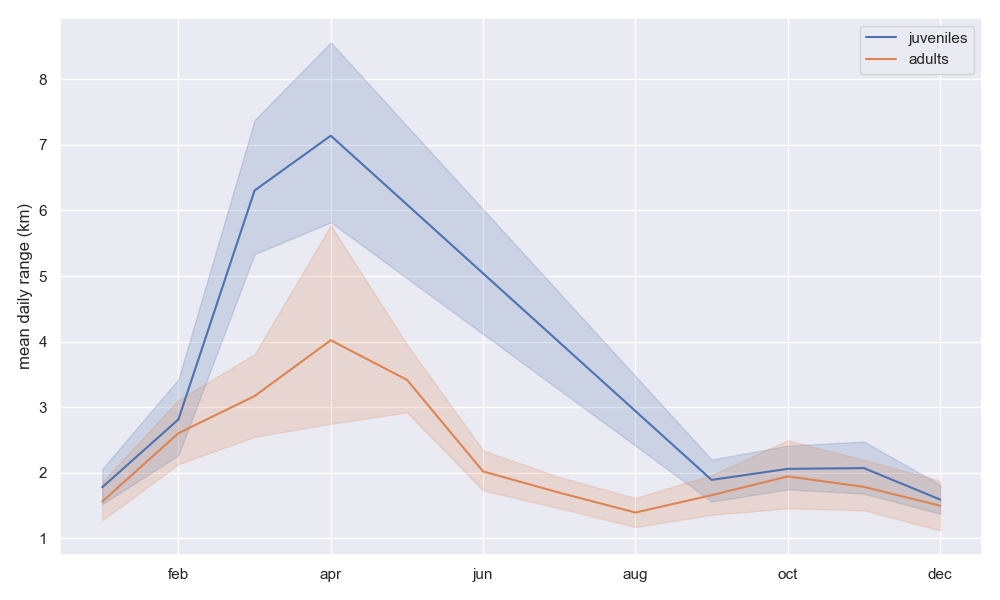

In [4]:
df_paris = df_movement.loc[df_movement.cohort.isin(['2020','2021','2022','2024'])]

df_juvs = df_paris.loc[df_paris.age == 0.]
df_adts = df_paris.loc[df_paris.age != 0.] # includes individuals of unknown age (age is nan)
s_juvs = df_juvs.groupby([pd.Grouper(level=0),df_juvs.index.get_level_values(1).month]).range.mean() /1000.
s_adts = df_adts.groupby([pd.Grouper(level=0),df_adts.index.get_level_values(1).month]).range.mean() /1000.

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(s_juvs.to_frame(), x='ts', y='range', label='juveniles')
sns.lineplot(s_adts.to_frame(), x='ts', y='range', label='adults')
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(range(2,13,2)))
ax.set_xticklabels(['feb','apr','jun','aug','oct','dec'])
ax.set_xlabel(None)
ax.set_ylabel('mean daily range (km)')
fig.tight_layout()